# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot
import seaborn as sns

import numpy

from sklearn.cluster import DBSCAN
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



id = '1VDFn9tpwO0ecnr5DiC7TQwg-GVoPJUEK'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('database.sqlite')  

# df2 = pd.read_csv(io.BytesIO(uploaded['Filename.csv']))

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

     |████████████████████████████████| 993kB 6.5MB/s 
Number of data points in our data (5000, 10)


Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...

[3 rows x 10 columns]

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


UserId  ... COUNT(*)
0  #oc-R115TNMSPFT9I7  ...        2
1  #oc-R11D9D7SHXIJB9  ...        3
2  #oc-R11DNU2NBKQ23Z  ...        2
3  #oc-R11O5J5ZVQE25C  ...        3
4  #oc-R12KPBODL2B5ZD  ...        2

[5 rows x 7 columns]

In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId  ... COUNT(*)
80638  AZY10LLTJ71NX  ...        5

[1 rows x 7 columns]

In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id  ...                                               Text
0   78445  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1  138317  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2  138277  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3   73791  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4  155049  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

[5 rows x 10 columns]

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id  ...                                               Text
0  64422  ...  My son loves spaghetti so I didn't hesitate or...
1  44737  ...  It was almost a 'love at first bite' - the per...

[2 rows x 10 columns]

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
#filtered out whole reviews

from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
# tqdm is for printing the status bar
word_counter = []
def filterised_text(text):
    preprocessed_text = []
    for sentance in tqdm(text):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        count = len(sentance.split())
        word_counter.append(count)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text

In [0]:
preprocessed_reviews = filterised_text(final['Text'].values)
final['preprocessed_reviews']  = preprocessed_reviews
preprocessed_reviews[1822]

100%|██████████| 4986/4986 [00:02<00:00, 2115.29it/s]


'keep work mix smoothies home love'

## [3.2] Preprocessing Review Summary

In [0]:
preprocessed_summary = filterised_text(final['Summary'].values)
final['preprocessed_summary']  = preprocessed_summary
preprocessed_summary[1822]

100%|██████████| 4986/4986 [00:01<00:00, 2961.53it/s]


'convienent'

# [4] Featurization

## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('care', 0.995854914188385), ('excellent', 0.9958145618438721), ('think', 0.9957082271575928), ('anything', 0.9956213235855103), ('overall', 0.9956039190292358), ('probably', 0.9955630302429199), ('matter', 0.995509147644043), ('certainly', 0.9954867959022522), ('liked', 0.9954566359519958), ('regret', 0.9954473376274109)]
[('perhaps', 0.9995949864387512), ('stand', 0.9994996190071106), ('varieties', 0.9994614720344543), ('goes', 0.999459981918335), ('hold', 0.9994559288024902), ('popcorn', 0.9994430541992188), ('normal', 0.9994139671325684), ('wow', 0.9994024038314819), ('experience', 0.9993988275527954), ('actual', 0.9993985295295715)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:05<00:00, 866.91it/s]

4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:36<00:00, 137.98it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

In [0]:
def plotWordCloud(text):

  #  https://www.geeksforgeeks.org/generating-word-cloud-python/

  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  min_font_size = 10).generate(text) 

  # plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 

  plt.show()
  
# fetch result from dataframe, where matchlabel== expected label, finally convert to string
def returnWordCloudString(df, matchlabel):
   return df['Text'][df.label == matchlabel].to_string()
  


## [5.2] Agglomerative Clustering

## Applying Agglomerative Clustering on AVG W2V

#### Two clusters

In [0]:
# K =2

clustering = AgglomerativeClustering(n_clusters=2)
labels = clustering.fit_predict(sent_vectors)

In [0]:
no_of_clusters = set(labels.flatten())
no_of_clusters

{0, 1}

In [0]:
# create duplicate copy of original dataframe as final2
final2 = final.copy()

# adding this labels result to duplicate copy dataframe
final2['label']= labels


# fetch reviews, those label==0, also convert to string
cluster_0 = returnWordCloudString(final2,0)

# fetch reviews, those label==1, also convert to string
cluster_1 = returnWordCloudString(final2,1)

cluster_0, cluster_1


('2546    Why is this $[...] when the same product is av...\n2547    We have used the Victor fly bait for 3 seasons...\n1145    I just received my shipment and could hardly w...\n1146    This was a really good idea and the final prod...\n2942    I\'m glad my 45lb cocker/standard poodle puppy ...\n1071    I have nine cats and they are crazy about thes...\n2187    These were shipped out the day after I ordered...\n2068    The description of this product is disceptive....\n2806    I use these to keep my finicky toddler\'s prote...\n2805    When we get very busy in our home, I like this...\n4097    Thank goodness for MexGrocer. We love this Pic...\n4098    This is a very different sauce - nothing like ...\n1332    i found this product doing a search for "edibl...\n1329    I have used this product multiple times.  In f...\n1328    I used Super Gold Luster Dust to create the mo...\n1331    This product allows me to make some really big...\n4320    This was a cute, affordable set for my 2 y/o

In [0]:
final.head(1)

Id  ... preprocessed_summary
2546  2774  ...         thirty bucks

[1 rows x 12 columns]

In [0]:
final2.head(1)

Id   ProductId  ... preprocessed_summary label
2546  2774  B00002NCJC  ...         thirty bucks     0

[1 rows x 13 columns]

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

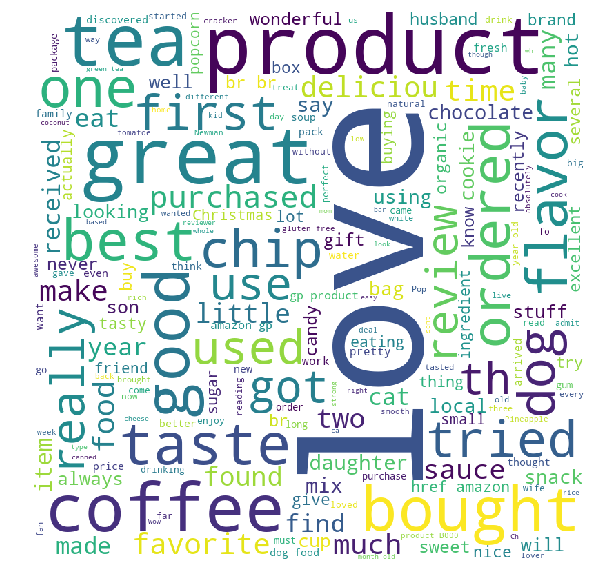

In [0]:
plotWordCloud(cluster_0)

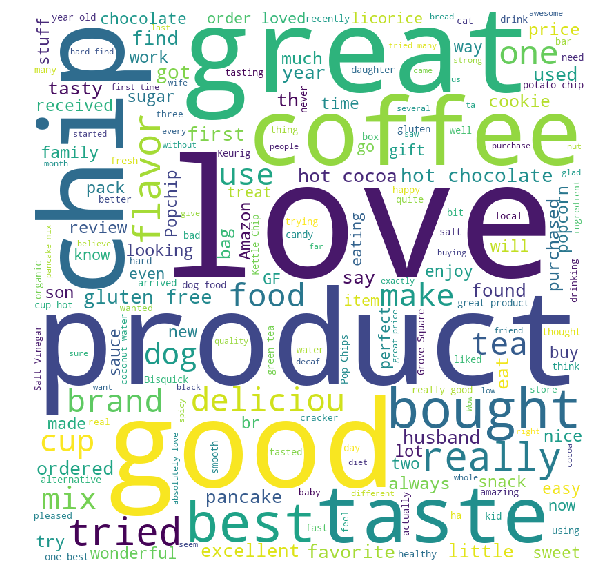

In [0]:
plotWordCloud(cluster_1)

#### 4 clusters

In [0]:
# K =4

clustering = AgglomerativeClustering(n_clusters=4)
labels = clustering.fit_predict(sent_vectors)

In [0]:
no_of_clusters = set(labels.flatten())
no_of_clusters

{0, 1, 2, 3}

In [0]:
# create duplicate copy of original dataframe as final4
final4 = final.copy()

# adding this labels result to duplicate copy dataframe
final4['label']= labels


# fetch reviews, those label==0, also convert to string
cluster_0 = returnWordCloudString(final4,0)

# fetch reviews, those label==1, also convert to string
cluster_1 = returnWordCloudString(final4,1)

# fetch reviews, those label==2, also convert to string
cluster_2 = returnWordCloudString(final4,2)

# fetch reviews, those label==3, also convert to string
cluster_3 = returnWordCloudString(final4,3)

cluster_list = (cluster_0, cluster_1,cluster_2,cluster_3)

cluster_0, cluster_1,cluster_2,cluster_3


('2546    Why is this $[...] when the same product is av...\n2547    We have used the Victor fly bait for 3 seasons...\n2187    These were shipped out the day after I ordered...\n2068    The description of this product is disceptive....\n2806    I use these to keep my finicky toddler\'s prote...\n2805    When we get very busy in our home, I like this...\n4098    This is a very different sauce - nothing like ...\n1329    I have used this product multiple times.  In f...\n4321    I only used one green with it\'s ball, etc. wit...\n4054    With all natural ingredients and no preservati...\n2477    Adzuki ( or Azuki) beans are ment to be used i...\n3466    This sauce is something of a permanent staple ...\n3469    I use this stuff on pretty much everything. Tu...\n3474    This is a great multi-use sauce.  Great for us...\n3476    Mae Ploy Sweet Chili Sauce is the best. I use ...\n3440    And I don\'t mean just for Asian sauces.  This ...\n3441    I use this in my banquet kitchen for so man

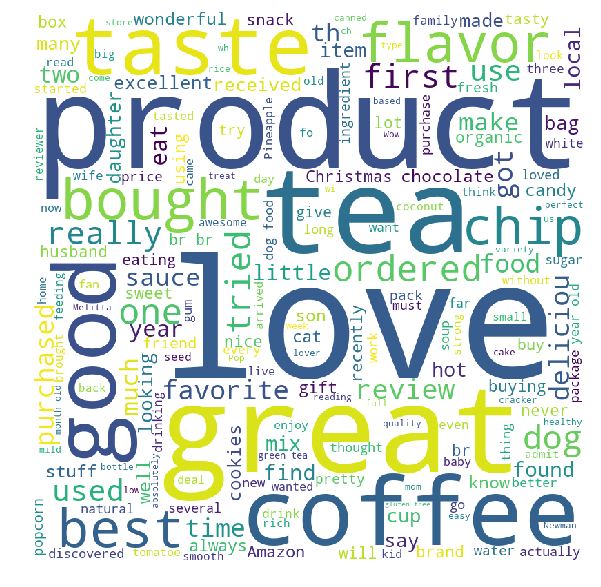

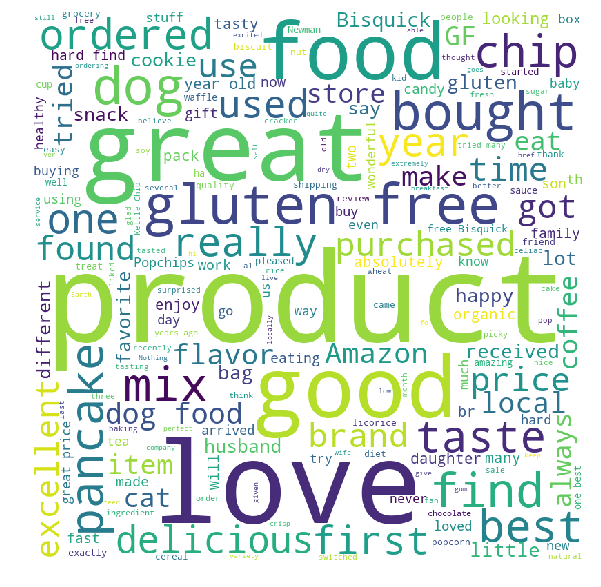

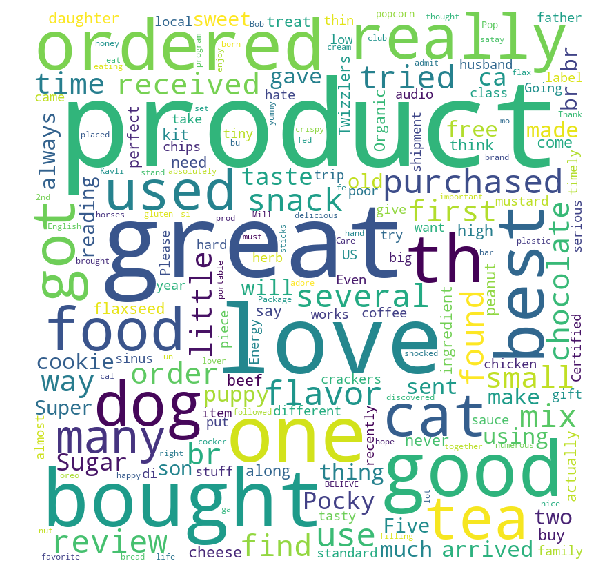

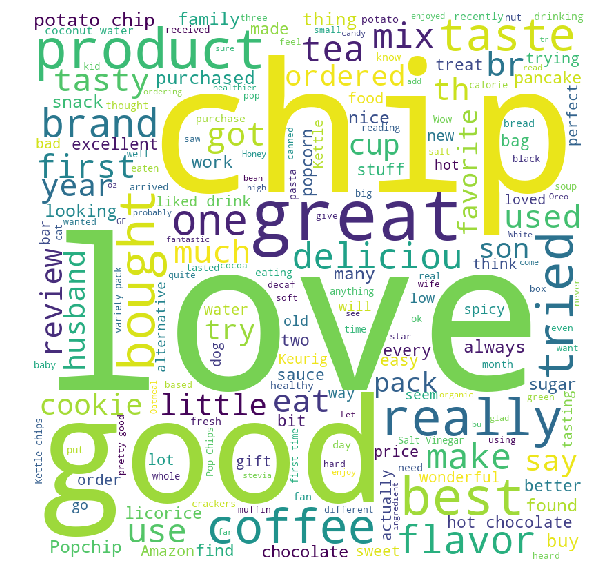

In [0]:
for i in cluster_list:
    plotWordCloud(i)

#### 6 clusters

In [0]:
# K =6

clustering = AgglomerativeClustering(n_clusters=6)
labels = clustering.fit_predict(sent_vectors)

In [0]:
# create duplicate copy of original dataframe as final4
final6 = final.copy()

# adding this labels result to duplicate copy dataframe
final6['label']= labels


# fetch reviews, those label==0, also convert to string
cluster_0 = returnWordCloudString(final6,0)

# fetch reviews, those label==1, also convert to string
cluster_1 = returnWordCloudString(final6,1)

# fetch reviews, those label==2, also convert to string
cluster_2 = returnWordCloudString(final6,2)

# fetch reviews, those label==3, also convert to string
cluster_3 = returnWordCloudString(final6,3)

# fetch reviews, those label==4, also convert to string
cluster_4 = returnWordCloudString(final6,4)

# fetch reviews, those label==5, also convert to string
cluster_5 = returnWordCloudString(final6,5)

cluster_list = (cluster_0, cluster_1,cluster_2,cluster_3,cluster_4,cluster_5)

cluster_0, cluster_1,cluster_2,cluster_3,cluster_4,cluster_5


('2546    Why is this $[...] when the same product is av...\n2547    We have used the Victor fly bait for 3 seasons...\n2187    These were shipped out the day after I ordered...\n2068    The description of this product is disceptive....\n2806    I use these to keep my finicky toddler\'s prote...\n2805    When we get very busy in our home, I like this...\n4098    This is a very different sauce - nothing like ...\n1329    I have used this product multiple times.  In f...\n4321    I only used one green with it\'s ball, etc. wit...\n4054    With all natural ingredients and no preservati...\n2477    Adzuki ( or Azuki) beans are ment to be used i...\n3466    This sauce is something of a permanent staple ...\n3469    I use this stuff on pretty much everything. Tu...\n3474    This is a great multi-use sauce.  Great for us...\n3476    Mae Ploy Sweet Chili Sauce is the best. I use ...\n3440    And I don\'t mean just for Asian sauces.  This ...\n3441    I use this in my banquet kitchen for so man

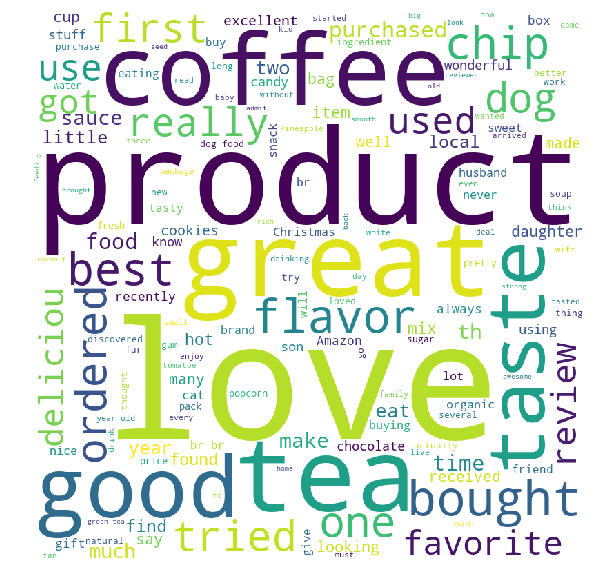

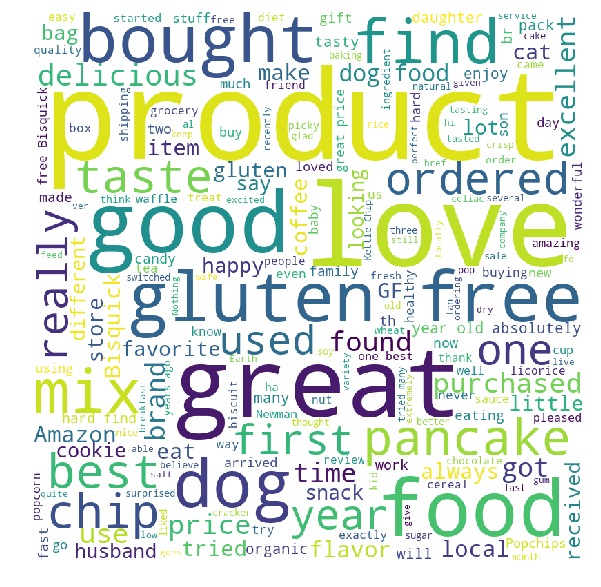

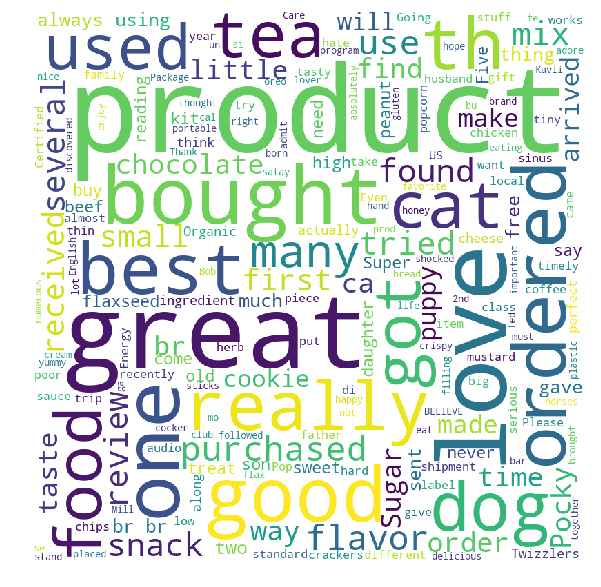

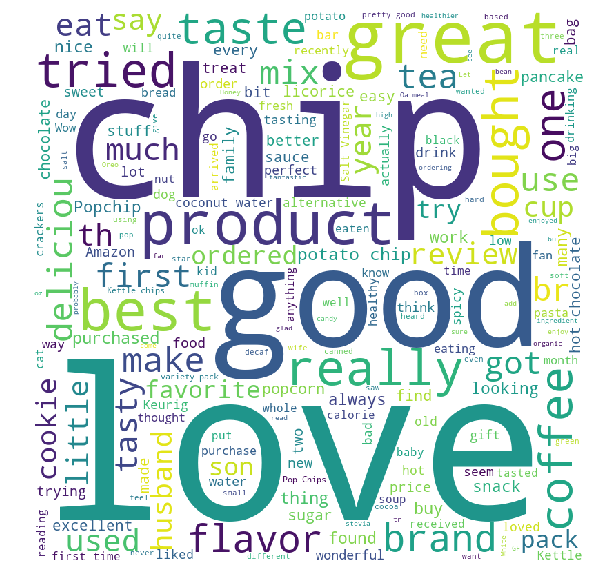

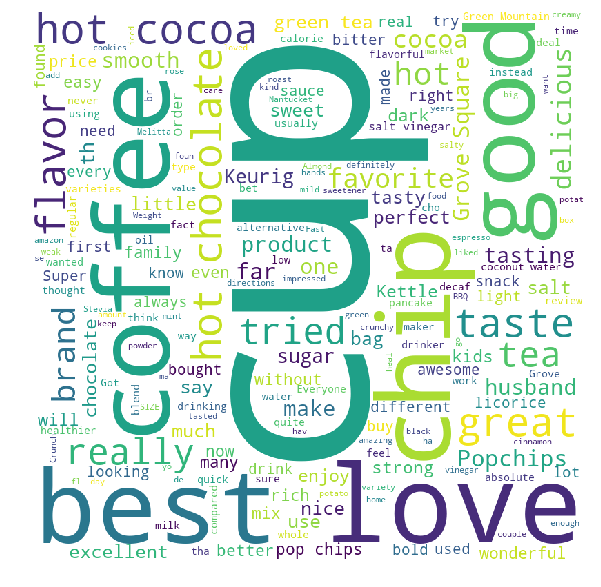

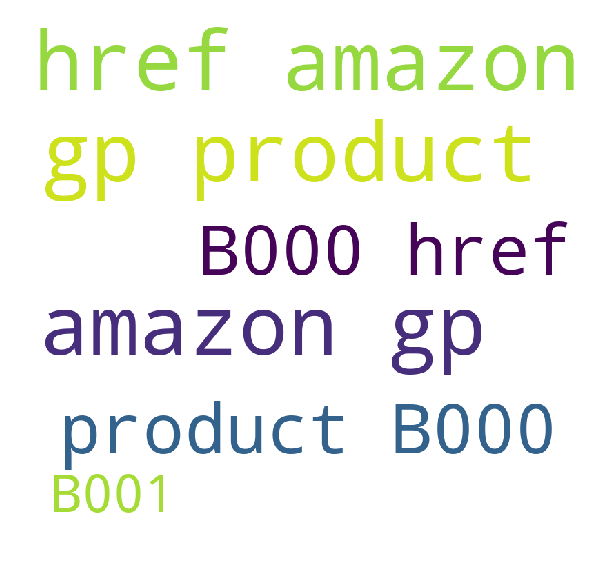

In [0]:
for i in cluster_list:
    plotWordCloud(i)
  

### Observation

All cluster contains mixed words, it not the good clustering example, Important to note when we are performing cluster size = 6. We can observe some noisy points

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

#### 2 clusters

In [0]:
# K =2

clustering = AgglomerativeClustering(n_clusters=2)
labels = clustering.fit_predict(tfidf_sent_vectors)

In [0]:
# create duplicate copy of original dataframe as final2
final_2 = final.copy()

# adding this labels result to duplicate copy dataframe
final_2['label']= labels


# fetch reviews, those label==0, also convert to string
cluster_0 = returnWordCloudString(final_2,0)

# fetch reviews, those label==1, also convert to string
cluster_1 = returnWordCloudString(final_2,1)

cluster_list = [cluster_0, cluster_1]


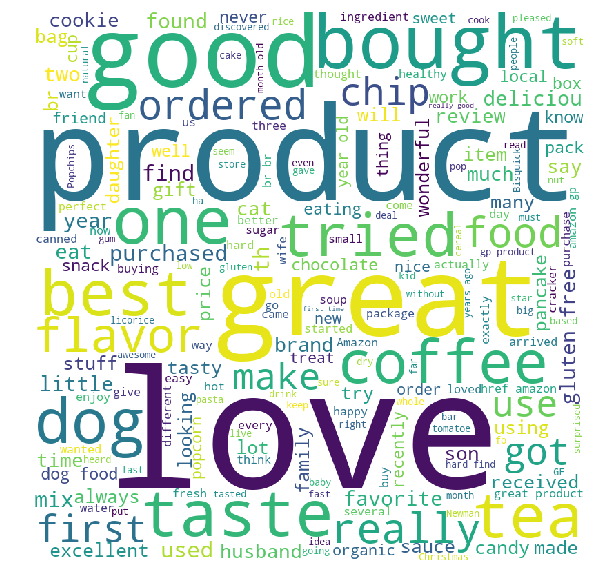

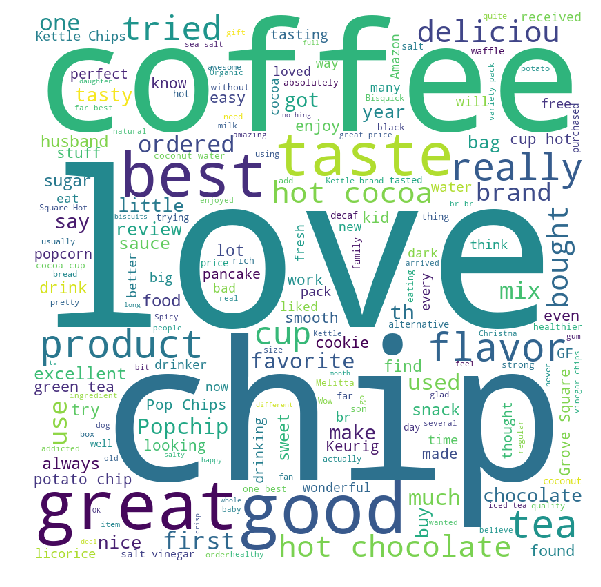

In [0]:
for i in cluster_list:
    plotWordCloud(i)
  

#### 4 clusters

In [0]:
# K =4

clustering = AgglomerativeClustering(n_clusters=4)
labels = clustering.fit_predict(tfidf_sent_vectors)

In [0]:
# create duplicate copy of original dataframe as final4
final_4 = final.copy()

# adding this labels result to duplicate copy dataframe
final_4['label']= labels


# fetch reviews, those label==0, also convert to string
cluster_0 = returnWordCloudString(final_4,0)

# fetch reviews, those label==1, also convert to string
cluster_1 = returnWordCloudString(final_4,1)

# fetch reviews, those label==2, also convert to string
cluster_2 = returnWordCloudString(final_4,2)

# fetch reviews, those label==3, also convert to string
cluster_3 = returnWordCloudString(final_4,3)

cluster_list = (cluster_0, cluster_1,cluster_2,cluster_3)

cluster_0, cluster_1,cluster_2,cluster_3


('1145    I just received my shipment and could hardly w...\n1146    This was a really good idea and the final prod...\n2942    I\'m glad my 45lb cocker/standard poodle puppy ...\n2187    These were shipped out the day after I ordered...\n2805    When we get very busy in our home, I like this...\n4097    Thank goodness for MexGrocer. We love this Pic...\n1332    i found this product doing a search for "edibl...\n1328    I used Super Gold Luster Dust to create the mo...\n1331    This product allows me to make some really big...\n4320    This was a cute, affordable set for my 2 y/o s...\n4322    <a href="http://www.amazon.com/gp/product/B000...\n4323    The Golf "set" arrived quickly and was just as...\n2477    Adzuki ( or Azuki) beans are ment to be used i...\n3471    Sooo good, I followed some advice and thought ...\n3481    Mae Ploy Sweet Chili Sauce is becoming a stand...\n3465    there where plenty of times we had to eat out....\n2144    My family has been in love with Baci\'s ever 

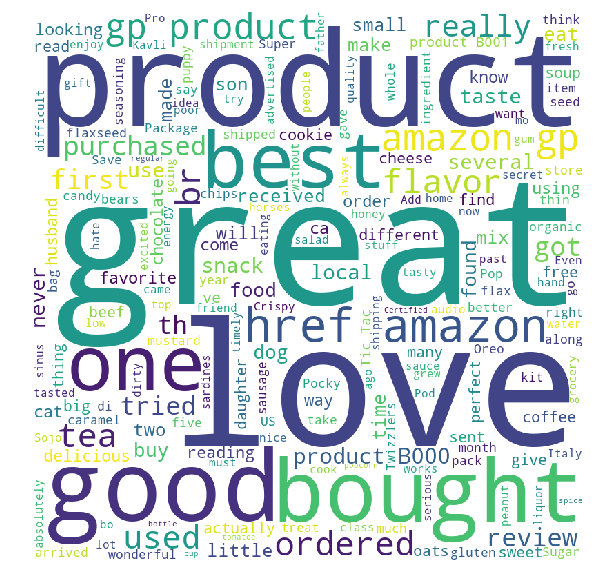

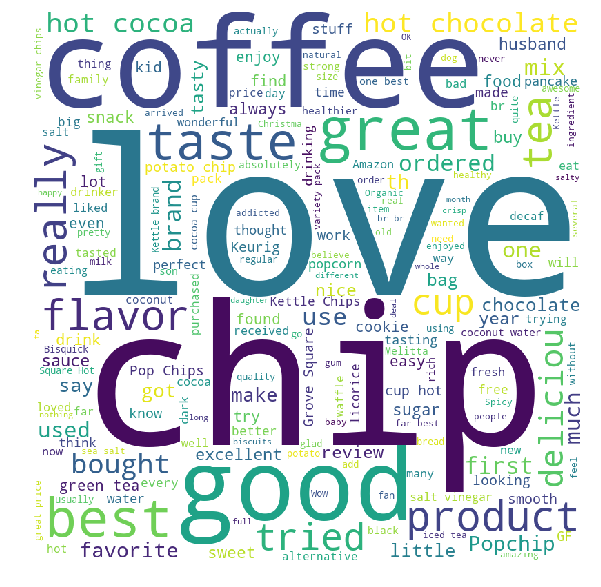

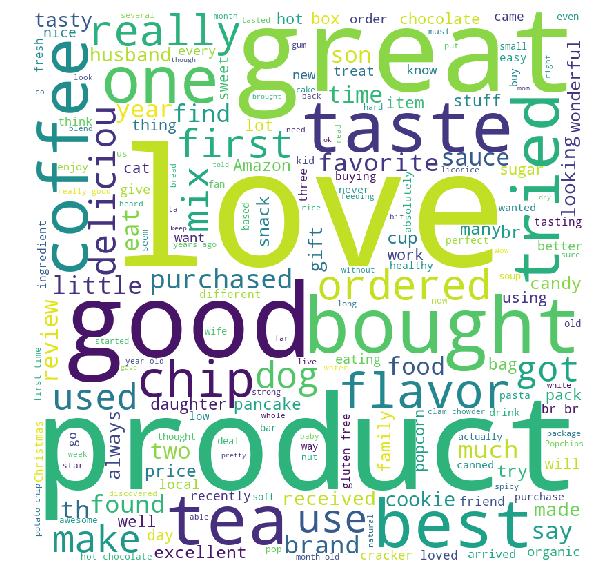

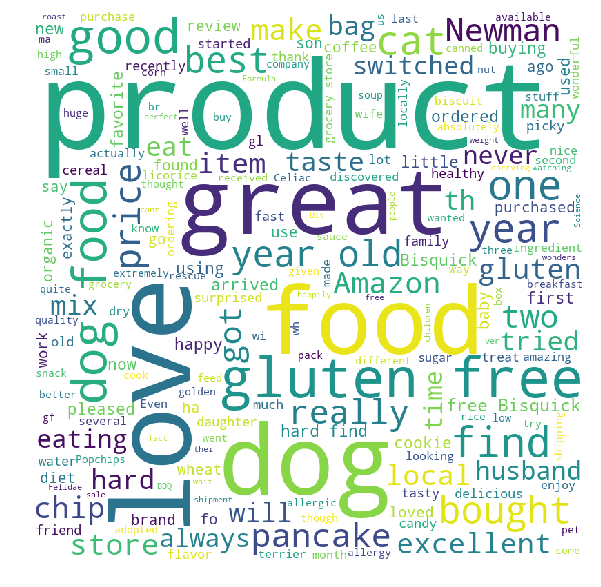

In [0]:
for i in cluster_list:
    plotWordCloud(i)
  

#### 6 clusters

In [0]:
# K =6

clustering = AgglomerativeClustering(n_clusters=6)
labels = clustering.fit_predict(tfidf_sent_vectors)

In [0]:
# create duplicate copy of original dataframe as final4
final_6 = final.copy()

# adding this labels result to duplicate copy dataframe
final_6['label']= labels


# fetch reviews, those label==0, also convert to string
cluster_0 = returnWordCloudString(final_6,0)

# fetch reviews, those label==1, also convert to string
cluster_1 = returnWordCloudString(final_6,1)

# fetch reviews, those label==2, also convert to string
cluster_2 = returnWordCloudString(final_6,2)

# fetch reviews, those label==3, also convert to string
cluster_3 = returnWordCloudString(final_6,3)

# fetch reviews, those label==4, also convert to string
cluster_4 = returnWordCloudString(final_6,4)

# fetch reviews, those label==5, also convert to string
cluster_5 = returnWordCloudString(final_6,5)

cluster_list = (cluster_0, cluster_1,cluster_2,cluster_3,cluster_4,cluster_5)

cluster_0, cluster_1,cluster_2,cluster_3,cluster_4,cluster_5


('2069    I bought this same brand from an online Indian...\n4099    This company is an American Classic been in bu...\n4096    I love Pico Pica.  It adds some flavor, and it...\n2479    Good stuff - like lentils you don\'t need to so...\n3467    not truly spicy my 2 year old loves this stuff...\n3468    I go to my mothers home one day she cooked fri...\n3477    kids love the sauce on many things... great on...\n3482    I was looking for a good sweet and sour sauce ...\n3480    I did not purchase this product off of Amazon....\n3479    I love this stuff.  I put it over chicken and ...\n3475    This sauce is an excellent blend of sweet and ...\n3478    Tried this sauce first at our favorite place t...\n3464    This is without doubt the finest sweet chilli ...\n3443    This sauce is good, but for my tastes it isn\'t...\n3448    I made crab rangoon and used this sauce as a d...\n3451    This sauce is very good on anything you cook o...\n3453    My whole family loves this sauce. I use it p

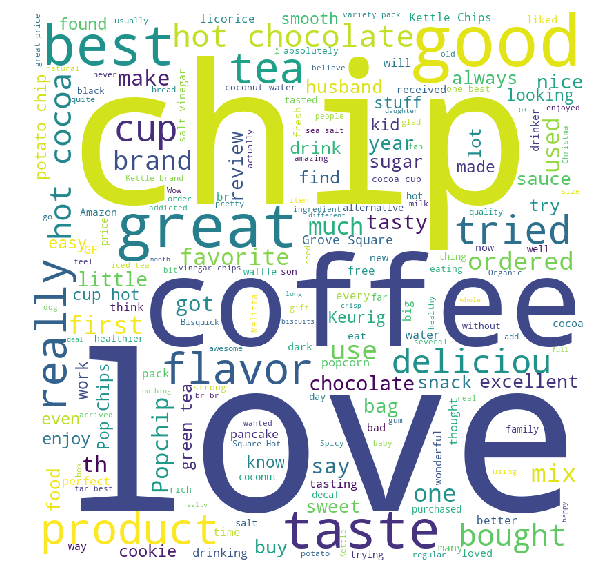

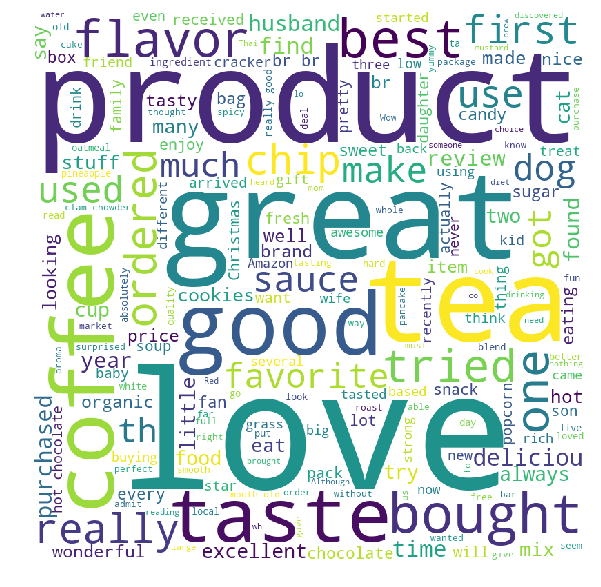

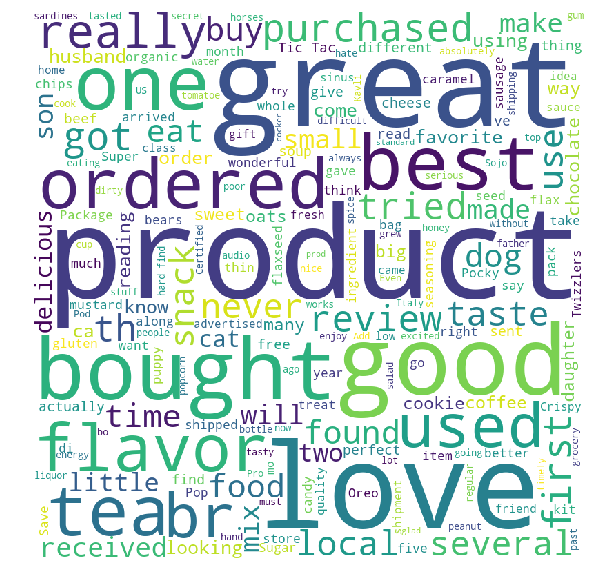

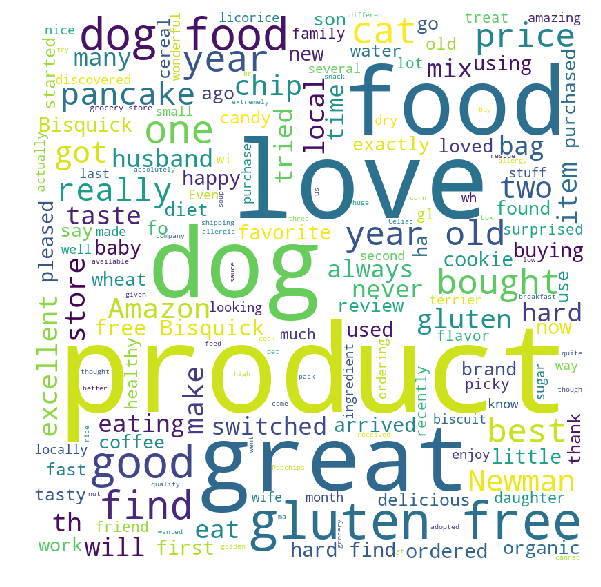

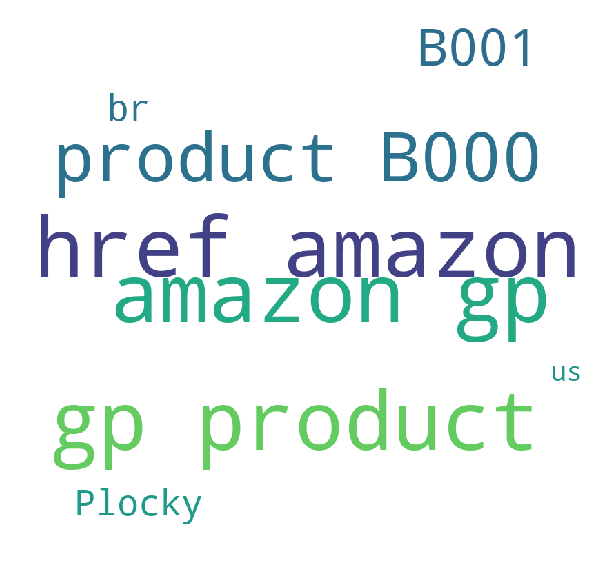

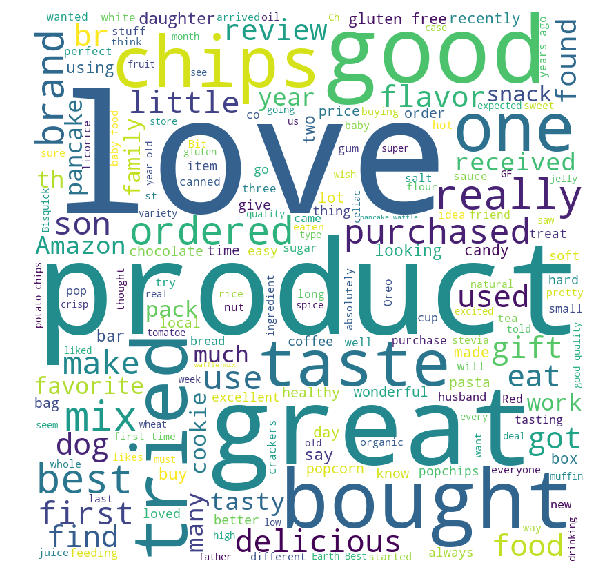

In [0]:
for i in cluster_list:
    plotWordCloud(i)

### Observation

All cluster contains mixed words, it not the good clustering example, Important to note when we are performing cluster size = 6. We can observe some noisy points

# [6] Conclusions

We have built model with 'different K' sizes for 'word2vec' and 'TFIDF weighted word2vec'. For all experiement we have consider **5000** datapoints.

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Models", "AvgW2V (Top words)", "TFIDF-W-W2V (Top words)"]

x.add_row(["No. of clusters=2 : ","love,product,great taste,coffee", "great, good,love,tea" ])
x.add_row(["No. of clusters=4 : ","love, great,product, gluten free,chip,delicious", "product, dog,chip,coffee,love" ])
x.add_row(["No. of clusters=6 : "," love,product", "great,taste" ])


print(x)

+----------------------+-------------------------------------------------+-------------------------------+
|        Models        |                AvgW2V (Top words)               |    TFIDF-W-W2V (Top words)    |
+----------------------+-------------------------------------------------+-------------------------------+
| No. of clusters=2 :  |         love,product,great taste,coffee         |      great, good,love,tea     |
| No. of clusters=4 :  | love, great,product, gluten free,chip,delicious | product, dog,chip,coffee,love |
| No. of clusters=6 :  |                   love,product                  |          great,taste          |
+----------------------+-------------------------------------------------+-------------------------------+


### Observation

All cluster contains mixed words, it not the good clustering example, Important to note when we are performing cluster size = 6. We can observe some noisy points